# Capstone Project Notebook


In [1]:
import pandas as pd
import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import urllib

print('Libraries imported.')

#!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup as bs

print('Beautiful soup imported.')

Libraries imported.
Beautiful soup imported.


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits'
html_doc = urllib.request.urlopen(url)

In [3]:
soup = bs(html_doc, 'html.parser')
table = soup.find_all('table')[0]

In [4]:
# get data from Table
row_marker = 0
numcities = 20
citylist = pd.DataFrame(columns=['City Name','Country','Latitude','Longitude'], index = range(0,numcities)) # I know the size
for cnt in range(0,6*numcities,6):
    column = table.find_all('td')[cnt] # Grab the first column
    textstring = (column.get_text().replace('\n',''))
    if textstring.find('[') != -1:
        textstring = textstring[0:textstring.find('[')]
    citylist.iat[row_marker,0] = textstring
    
    column = table.find_all('td')[cnt+1] # Grab the next column
    textstring = (column.get_text().replace('\n',''))
    citylist.iat[row_marker,1] = textstring
    
    row_marker += 1
    
datasize = citylist.shape
print('Size of Dataframe: '+str(datasize))

Size of Dataframe: (20, 4)


In [5]:
citylist.head(20)

,City Name,Country,Latitude,Longitude
0,London,United Kingdom,NaN,NaN
1,Berlin,Germany,NaN,NaN
2,Madrid,Spain,NaN,NaN
3,Rome,Italy,NaN,NaN
4,Paris,France,NaN,NaN
5,Bucharest,Romania,NaN,NaN
6,Vienna,Austria,NaN,NaN
7,Hamburg,Germany,NaN,NaN
8,Warsaw,Poland,NaN,NaN
9,Budapest,Hungary,NaN,NaN


In [6]:
for cnt in range(0,20):
    address = citylist.iloc[cnt,0]+','+citylist.iloc[cnt,1]
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    citylist.iat[cnt,2] = location.latitude
    citylist.iat[cnt,3] = location.longitude

     
citylist.head()

,City Name,Country,Latitude,Longitude
0,London,United Kingdom,51.5073,-0.127647
1,Berlin,Germany,52.517,13.3889
2,Madrid,Spain,40.4167,-3.70358
3,Rome,Italy,41.8948,12.4853
4,Paris,France,48.8566,2.3515


In [7]:
CLIENT_ID = 'GAKODM4LPGEUSDE4NFZUMTWDTMGN1JUAJZLISCRAMHKW5DYW' # your Foursquare ID
CLIENT_SECRET = 'JZDLW4BA33DDRBTABFIC5O4JTWXJY5TVA2AKRADI5YP12OK4' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GAKODM4LPGEUSDE4NFZUMTWDTMGN1JUAJZLISCRAMHKW5DYW
CLIENT_SECRET:JZDLW4BA33DDRBTABFIC5O4JTWXJY5TVA2AKRADI5YP12OK4


In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    sectionlist =  ['food', 'drinks', 'coffee', 'shops', 'arts']
    venues_list=[]
    
    for cnt in range(0,len(sectionlist)):
    
        section = sectionlist[cnt]
        print('Section '+ section)
   
        for name, lat, lng in zip(names, latitudes, longitudes):
                       
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                section,
                LIMIT)
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            skipcounter = 0
            for cnt in range(0,len(results)):
            
                try:
                                
                # return only relevant information for each nearby venue
                    venues_list.append([(
                    name, 
                    results[cnt]['venue']['location']['postalCode'],
                    results[cnt]['venue']['name'],
                    results[cnt]['venue']['location']['lat'], 
                    results[cnt]['venue']['location']['lng'],  
                    results[cnt]['venue']['categories'][0]['name'])])
                
                except:
                    skipcounter = skipcounter+1
                
            print('City ' + name + ': ' + str(skipcounter) + ' venues skipped')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Postal Code',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
european_venues = getNearbyVenues(names=citylist['City Name'],
                                   latitudes=citylist['Latitude'],
                                   longitudes=citylist['Longitude']
                                  )

Section food
City London: 1 venues skipped
City Berlin: 1 venues skipped
City Madrid: 6 venues skipped
City Rome: 19 venues skipped
City Paris: 0 venues skipped
City Bucharest: 52 venues skipped
City Vienna: 8 venues skipped
City Hamburg: 4 venues skipped
City Warsaw: 38 venues skipped
City Budapest: 11 venues skipped
City Barcelona: 6 venues skipped
City Munich: 3 venues skipped
City Milan: 11 venues skipped
City Prague: 7 venues skipped
City Sofia: 33 venues skipped
City Brussels: 2 venues skipped
City Birmingham: 3 venues skipped
City Cologne: 2 venues skipped
City Naples: 34 venues skipped
City Stockholm: 14 venues skipped
Section drinks
City London: 1 venues skipped
City Berlin: 0 venues skipped
City Madrid: 8 venues skipped
City Rome: 11 venues skipped
City Paris: 0 venues skipped
City Bucharest: 41 venues skipped
City Vienna: 10 venues skipped
City Hamburg: 1 venues skipped
City Warsaw: 45 venues skipped
City Budapest: 8 venues skipped
City Barcelona: 14 venues skipped
City Muni

In [12]:
european_venues.tail()

,City,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category
8418,Stockholm,118 26,Filmstaden Söder,59.314108,18.070973,Multiplex
8419,Stockholm,111 53,Stora Scenen,59.331325,18.071584,Concert Hall
8420,Stockholm,111 48,Stallet,59.330912,18.075786,Concert Hall
8421,Stockholm,116 22,Kellys,59.314398,18.074586,Rock Club
8422,Stockholm,111 49,Moderna Dansteatern,59.327330,18.083755,Dance Studio


In [13]:
#print(european_venues.shape)

#european_venues.drop_duplicates(subset=None, keep='first', inplace=True)

#print(european_venues.shape)


print('The dataframe has {} postal codes/neighborhoods and {} venues.'.format(
        len(european_venues['Postal Code'].unique()),
        european_venues.shape[0]
    )
)

The dataframe has 1478 postal codes/neighborhoods and 8423 venues.


In [14]:
print('There are {} unique categories.'.format(len(european_venues['Venue Category'].unique())))

There are 292 unique categories.


In [15]:
for cnt in range(0,citylist.shape[0]):
    blurb = european_venues.loc[european_venues['City']==citylist.iloc[cnt,0]].groupby('Postal Code').count()
    print(citylist.iloc[cnt,0]+': '+str(blurb.shape[0])+' neighborhoods/postal codes')


London: 422 neighborhoods/postal codes
Berlin: 18 neighborhoods/postal codes
Madrid: 17 neighborhoods/postal codes
Rome: 25 neighborhoods/postal codes
Paris: 14 neighborhoods/postal codes
Bucharest: 181 neighborhoods/postal codes
Vienna: 17 neighborhoods/postal codes
Hamburg: 20 neighborhoods/postal codes
Warsaw: 159 neighborhoods/postal codes
Budapest: 58 neighborhoods/postal codes
Barcelona: 28 neighborhoods/postal codes
Munich: 27 neighborhoods/postal codes
Milan: 21 neighborhoods/postal codes
Prague: 23 neighborhoods/postal codes
Sofia: 27 neighborhoods/postal codes
Brussels: 11 neighborhoods/postal codes
Birmingham: 253 neighborhoods/postal codes
Cologne: 24 neighborhoods/postal codes
Naples: 18 neighborhoods/postal codes
Stockholm: 128 neighborhoods/postal codes


### London and Birmingham have an extremely large number of postal codes - in the UK the postal code areas are quite small. For this reason, we will drop the final digits/letters for these postal codes, generating larger neighborhoods. In Warsaw and Bucharest we will do the same, dropping two final digits. In Stockholm we will drop the final digit.

In [16]:
european_venues.loc[european_venues['City']=='London','Postal Code'] = european_venues.loc[european_venues['City']=='London','Postal Code'].str[:-2]

In [17]:
european_venues.loc[european_venues['City']=='Birmingham','Postal Code'] = european_venues.loc[european_venues['City']=='Birmingham','Postal Code'].str[:-2]

In [18]:
european_venues.loc[european_venues['City']=='Warsaw','Postal Code'] = european_venues.loc[european_venues['City']=='Warsaw','Postal Code'].str[:-2]

In [19]:
european_venues.loc[european_venues['City']=='Bucharest','Postal Code'] = european_venues.loc[european_venues['City']=='Bucharest','Postal Code'].str[:-2]

In [20]:
european_venues.loc[european_venues['City']=='Stockholm','Postal Code'] = european_venues.loc[european_venues['City']=='Stockholm','Postal Code'].str.slice(0,-1)

In [21]:
for cnt in range(0,citylist.shape[0]):
    blurb = european_venues.loc[european_venues['City']==citylist.iloc[cnt,0]].groupby('Postal Code').count()
    print(citylist.iloc[cnt,0]+': '+str(blurb.shape[0])+' neighborhoods/postal codes')

London: 100 neighborhoods/postal codes
Berlin: 18 neighborhoods/postal codes
Madrid: 17 neighborhoods/postal codes
Rome: 25 neighborhoods/postal codes
Paris: 14 neighborhoods/postal codes
Bucharest: 58 neighborhoods/postal codes
Vienna: 17 neighborhoods/postal codes
Hamburg: 20 neighborhoods/postal codes
Warsaw: 17 neighborhoods/postal codes
Budapest: 58 neighborhoods/postal codes
Barcelona: 28 neighborhoods/postal codes
Munich: 27 neighborhoods/postal codes
Milan: 21 neighborhoods/postal codes
Prague: 23 neighborhoods/postal codes
Sofia: 27 neighborhoods/postal codes
Brussels: 11 neighborhoods/postal codes
Birmingham: 36 neighborhoods/postal codes
Cologne: 24 neighborhoods/postal codes
Naples: 18 neighborhoods/postal codes
Stockholm: 41 neighborhoods/postal codes


In [22]:
print(str(european_venues.shape[0]) + ' Venues')
print(str(european_venues.groupby('Postal Code').count().shape[0]) + ' Neighborhoods')

8423 Venues
589 Neighborhoods


In [23]:
# one hot encoding
european_venues_onehot = pd.get_dummies(european_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
european_venues_onehot['Postal Code'] = european_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [european_venues_onehot.columns[-1]] + list(european_venues_onehot.columns[:-1])
european_venues_onehot = european_venues_onehot[fixed_columns]

european_venues_onehot.head()

,Postal Code,Abruzzo Restaurant,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Zoo Exhibit
0,WC2N 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WC2N 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SW1Y 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SW1Y 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,WC2N 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
european_grouped = european_venues_onehot.groupby('Postal Code').mean().reset_index()

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = european_grouped['Postal Code']

for ind in np.arange(european_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(european_grouped.iloc[ind, :], num_top_venues)

# Cluster the neighborhoods

[  8  21  18  88  12  17   8  49   7 340   8  13]


Text(0, 0.5, 'Number of neighborhoods/postal codes')

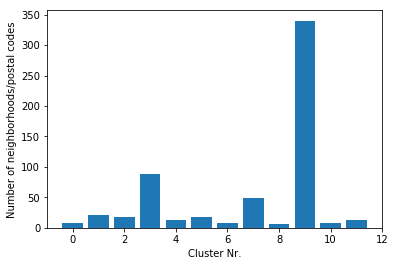

In [31]:
# set number of clusters
kclusters = 12

european_grouped_clustering = european_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(european_grouped_clustering)
unique, counts = np.unique(kmeans.labels_, return_counts=True)

print(counts)
       

import matplotlib.pyplot as plt

plt.figure()
plt.bar(unique,counts)
plt.xlabel('Cluster Nr.')
plt.ylabel('Number of neighborhoods/postal codes')

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head(10)
#neighborhoods_venues_sorted.shape
european_merged = european_venues

# merge to add city information
european_merged = european_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

european_merged.head()

,City,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,WC2N 4,Barrafina,51.509427,-0.125894,Spanish Restaurant,7,Theater,Coffee Shop,Café,Pub,Speakeasy,Spanish Restaurant,North Indian Restaurant,Opera House,Mexican Restaurant,Tea Room
1,London,WC2N 4,Tandoor Chop House,51.509103,-0.125987,North Indian Restaurant,7,Theater,Coffee Shop,Café,Pub,Speakeasy,Spanish Restaurant,North Indian Restaurant,Opera House,Mexican Restaurant,Tea Room
2,London,SW1Y 4,Milos,51.508117,-0.133341,Greek Restaurant,9,Theater,Bar,Comedy Club,Japanese Restaurant,Greek Restaurant,Cocktail Bar,Bakery,English Restaurant,Ethiopian Restaurant,Event Space
3,London,SW1Y 4,Ole & Steen,51.509219,-0.132597,Bakery,9,Theater,Bar,Comedy Club,Japanese Restaurant,Greek Restaurant,Cocktail Bar,Bakery,English Restaurant,Ethiopian Restaurant,Event Space
4,London,WC2N 4,Wahaca,51.510221,-0.124524,Mexican Restaurant,7,Theater,Coffee Shop,Café,Pub,Speakeasy,Spanish Restaurant,North Indian Restaurant,Opera House,Mexican Restaurant,Tea Room


## Examine Clusters

In [80]:
european_merged.loc[european_merged['Cluster Labels'] == 7, european_merged.columns[[1,2] + list(range(5, european_merged.shape[1]))]]

,Postal Code,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,WC2N 4,Barrafina,Spanish Restaurant,7,Theater,Coffee Shop,Café,Pub,Speakeasy,Spanish Restaurant,North Indian Restaurant,Opera House,Mexican Restaurant,Tea Room
1,WC2N 4,Tandoor Chop House,North Indian Restaurant,7,Theater,Coffee Shop,Café,Pub,Speakeasy,Spanish Restaurant,North Indian Restaurant,Opera House,Mexican Restaurant,Tea Room
4,WC2N 4,Wahaca,Mexican Restaurant,7,Theater,Coffee Shop,Café,Pub,Speakeasy,Spanish Restaurant,North Indian Restaurant,Opera House,Mexican Restaurant,Tea Room
8,WC2H 9,Dishoom,Indian Restaurant,7,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Pizza Place,Dance Studio,Record Shop,Performing Arts Venue,Chocolate Shop,Breakfast Spot
12,WC2E 7,Franco Manca,Pizza Place,7,Coffee Shop,Korean Restaurant,Italian Restaurant,Theater,History Museum,Pizza Place,Gift Shop,Fabric Shop,English Restaurant,Ethiopian Restaurant
15,WC2H 9,Hawksmoor Seven Dials,Steakhouse,7,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Pizza Place,Dance Studio,Record Shop,Performing Arts Venue,Chocolate Shop,Breakfast Spot
16,WC2H 9,Fabrique,Bakery,7,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Pizza Place,Dance Studio,Record Shop,Performing Arts Venue,Chocolate Shop,Breakfast Spot
20,WC2H 9,L'Atelier de Joel Robuchon,French Restaurant,7,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Pizza Place,Dance Studio,Record Shop,Performing Arts Venue,Chocolate Shop,Breakfast Spot
21,W1F 9,Kiln,Thai Restaurant,7,Coffee Shop,Taiwanese Restaurant,Nightclub,Thai Restaurant,Bike Shop,Steakhouse,Vegetarian / Vegan Restaurant,Chocolate Shop,Russian Restaurant,Café
27,W1D 4,Hoppers,Sri Lankan Restaurant,7,Cocktail Bar,Coffee Shop,Restaurant,Jazz Club,Sri Lankan Restaurant,Seafood Restaurant,Lounge,Liquor Store,Café,Theater


## List of venues which could be possible concert locations

In [61]:
venues_of_interest = ['Rock Club','Concert Hall','Piano Bar','Irish Pub','Jazz Club','Performing Arts Venue','Theater','Karaoke Bar','Music Venue','Opera House','Amphitheater','Salsa Club','Country Dance Club','Cultural Center','General Entertainment']

## Set reference venue

In [86]:
reference_cluster = european_merged['Cluster Labels'].loc[european_merged['Venue'] == "Ampere"]

#reference_cluster = european_merged['Cluster Labels'].loc[european_merged['Venue'] == "Costello Club"]

#reference_cluster = european_merged['Cluster Labels'].loc[european_merged['Venue'] == "VK Concerts"]

In [87]:
reference_cluster = reference_cluster.iloc[0]
print('Reference cluster is number '+str(reference_cluster))


european_venue_list = european_merged.loc[european_merged['Venue Category'].isin(venues_of_interest)]

european_venue_list.head(10)

Reference cluster is number 3


,City,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
308,Rome,00145,Scholars Lounge,41.896286,12.480130,Irish Pub,9,Irish Pub,Zoo Exhibit,Fast Food Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market
501,Bucharest,0300,St. Patrick,44.431520,26.099823,Irish Pub,9,Romanian Restaurant,Gastropub,Cocktail Bar,Café,Pub,Roof Deck,Beer Bar,Greek Restaurant,Lounge,Steakhouse
587,Vienna,1010,Pickwick's,48.212625,16.373878,Irish Pub,3,Café,Restaurant,Austrian Restaurant,Italian Restaurant,Cocktail Bar,History Museum,Bar,Supermarket,Coffee Shop,Nightclub
956,Munich,80331,Kilians,48.138720,11.574556,Irish Pub,9,Café,German Restaurant,Bavarian Restaurant,Clothing Store,Sporting Goods Shop,Bar,Restaurant,Department Store,Museum,Gourmet Shop
1015,Munich,80336,Kennedy's Irish Bar & Restaurant,48.134101,11.567233,Irish Pub,3,Café,Supermarket,Art Gallery,Irish Pub,Vegetarian / Vegan Restaurant,Bavarian Restaurant,Theater,Cocktail Bar,Movie Theater,Jazz Club
1755,London,W1D 4,Ronnie Scott's Jazz Club,51.513416,-0.131648,Jazz Club,7,Cocktail Bar,Coffee Shop,Restaurant,Jazz Club,Sri Lankan Restaurant,Seafood Restaurant,Lounge,Liquor Store,Café,Theater
1859,Berlin,10117,Vincent,52.521533,13.386339,Piano Bar,9,German Restaurant,Café,Bar,Art Gallery,Clothing Store,Coffee Shop,Wine Bar,Theater,Chocolate Shop,Asian Restaurant
1952,Madrid,28004,Microteatro por dinero,40.421602,-3.704047,Performing Arts Venue,9,Cocktail Bar,Restaurant,Café,Tapas Restaurant,Bar,Coffee Shop,Lounge,Bookstore,Market,Theater
1972,Madrid,28013,Costello Club,40.419530,-3.700692,Concert Hall,9,Coffee Shop,Bookstore,Café,Sporting Goods Shop,Tapas Restaurant,Spanish Restaurant,Clothing Store,Bar,Nightclub,Chocolate Shop
2011,Madrid,28004,Toni 2,40.422577,-3.694798,Piano Bar,9,Cocktail Bar,Restaurant,Café,Tapas Restaurant,Bar,Coffee Shop,Lounge,Bookstore,Market,Theater


In [88]:
proposed_venues = european_venue_list.loc[european_venue_list['Cluster Labels'] == reference_cluster]
proposed_venues = proposed_venues[['City','Postal Code','Venue','Venue Category','Cluster Labels']]

In [89]:
proposed_venues.shape

(154, 5)

In [90]:
proposed_venues

,City,Postal Code,Venue,Venue Category,Cluster Labels
587,Vienna,1010,Pickwick's,Irish Pub,3
1015,Munich,80336,Kennedy's Irish Bar & Restaurant,Irish Pub,3
2289,Vienna,1010,Porgy & Bess,Jazz Club,3
2320,Vienna,1010,Flanagans Irish Pub,Irish Pub,3
2370,Vienna,1090,Charlie P's,Irish Pub,3
2373,Vienna,1010,Molly Darcy's,Irish Pub,3
2508,Warsaw,00-6,miejsce Chwila,Rock Club,3
2525,Warsaw,00-6,12on14 Jazz Club,Jazz Club,3
2748,Munich,80333,Rote Sonne,Music Venue,3
2762,Munich,81667,Muffathalle,Music Venue,3
